# Lupulagem e a conversão de humulone em iso-humulone considerando saturação

* O lúpulo é um componente fundamental da cerveja, que confere o amargor para equilibrar o dulçor do malte.

* Mas esse amargor não está disponível de forma direta.

* É necessário um processo químico, obtido através da fervura do mosto, para que o amargor seja bem aproveitado.

* Vamos analisar alguns modelos para tratar esse processo.

In [15]:
using DifferentialEquations
using Statistics
using LsqFit
using Optim
using Plots
using Images

## Forma e composição do lúpulo

* O [lúpulo](https://en.wikipedia.org/wiki/Hops) é uma flor de uma trepadeira da família [Cannabaceae](https://pt.wikipedia.org/wiki/Cannabaceae).

* Os seus principais componentes são os óleos essenciais (aroma) e os alfa-ácidos (amargor).

* Os alfa-ácidos, em si, têm baixa solubilidade e pouco grau de amargor.

* Durante a fervura do mosto, os alfa-ácidos são transformados em iso-alfa-ácidos, que possuem solubilidade e grau de amargor bem maiores, sendo a principal componente de amargor na cerveja.

![hop cones](../../../_assets/attachments/img/hopcones_farm.jpg)

![Hop anatomy](../../../_assets/attachments/img/HopAnatomy_600x400.jpg)

![Hop composition](../../../_assets/attachments/img/CompositionofHopCones.png)

![Total resins](../../../_assets/attachments/img/TotalResins_600.png)

## Humulone

* Há vários tipos de alfa-ácidos (humulone, co-humulone, ad-humulone, etc.) e iso-alfa-ácidos (versões *cis* e *trans* de cada).

* O mais abundante dos alfa-ácidos é o [humulone](https://en.wikipedia.org/wiki/Humulone).

* No que se segue, vamos considerar dados de utilização do humulone, obtidos em laboratório, para ajustar alguns modelos e escolher o que nos dá o melhor ajuste.

![Alpha-acids distribution](../../../_assets/attachments/img/distributionofalphaacids.png)

## Dissociação, isomerização e degradação

* Ao ser adicionado ao mosto, durante e ao longo da fervura, os seguinte principais processos acontecem:
  * (Dissociação) Os alfa-ácidos se dissociam dos outros componentes do lúpulo;
  * (Isomerização) Os alfa-ácidos são convertidos em iso-alfa-ácidos, a taxas de reação dependentes da temperatura e do pH.
  * (Degradação) Os iso-alfa-ácidos são transformados, por hidrólise, em outras substâncias sem propriedades significativas de amargor.

* Podemos representar essas reações da seguinte forma, onde $A$ indica um alfa-ácido; $A_\mathrm{iso}$, um isômero de alfa-ácido; $R$ o conjunto dos outros componentes do lúpulo; e $S$ o conjunto de substâncias degradadas dos iso-alfa-ácidos:
  * (Dissociação) $AR \rightarrow pA + (1-p)R$;
  * (Isomerização) $A + H_2 O \rightleftharpoons A_{\mathrm{iso}} + H_2 O$;
  * (Hidrólise) $A_{\mathrm{iso}} + H_2 O \rightarrow S$.
  
* O fator $p$ indica a porcentagem de alfa-ácidos em $AR$.

![Isomerization and degradation](../../../_assets/attachments/img/IsomerizationandDegradation.png)

## Equações de reação

* Vamos denotar as concentrações de $AR$, $R$, $A$, $A_\mathrm{iso}$, $H_2O$ e $S$ por $b$, $r$, $a$, $i$ e $h$.

* Sem a saturação, as reações nos levam às equações parcialmente acopladas

$$ \begin{cases}
  b' = - \kappa_0 b, \\
  r' = \kappa_0 (1-p)b, \\
  a' = \kappa_0 pb - \kappa_1 ah + \kappa_{-1}ih, \\
  i' = \kappa_1 ah - \kappa_{-1}ih - \kappa_2ih, \\
  s' = \kappa_2ih.
\end{cases}
$$

* Quando $a$ é fornecido diretamente, basta nos concentrarmos no sistema

$$ \begin{cases}
  a' = -\kappa_1 ah + \kappa_{-1}ih, \\
  i' = \kappa_1 ah - \kappa_{-1}ih - \kappa_2ih, \\
\end{cases}
$$

* Na prática, $H_2O$ é abundante, com as outras substâncias sendo da ordem de miligramas por litro, ou, aproximadamente, partes por milhão, de tal forma que $h\approx 1$.

* Além disso, a reação inversa à de isomerização é negligível. Isso nos leva ao sistema

$$ \begin{cases}
  a' = -\kappa_1 a, \\
  i' = \kappa_1 a - \kappa_2i, \\
\end{cases}
$$

## Solubilidade

* A principal característica que buscamos considerar é a solubilidade dos alfa-ácidos.

* Os modelos usuais de cálculo de utilização não levam a solubilidade em consideração.

* A solubilidade limita a taxa de reação, ao limitar a quantidade de alfa-ácidos disponível para a isomerização.

* Vamos comparar o modelo sem saturação com os três modelos de saturação discutidos em trabalho sobre ..., além de uma variação de um desses modelos.

* Como as solubilidades dos iso-alfa-ácidos e dos ácidos degradados são bem mais altas, vamos considerar a solubilidade apenas dos alfa-ácidos. No caso, apenas do humulone.

![Bitter acids of hops](../../../_assets/attachments/img/Spetsig-BitterAcidsofHops.png)

* Com saturação $f = f(a, \bar a)$, consideramos

$$ \begin{cases}
  a' = -\kappa_1 f(a, \bar a), \\
  i' = \kappa_1 f(a, \bar a) - \kappa_2i, \\
\end{cases}
$$

* Temos 
  * $f(a, \bar a) \approx a$, para $a\ll \bar a$;
  * $f(a, \bar a) \approx \bar a$, para $a \approx \bar a$.

### Funções de modelagem de saturação

In [23]:
nosat(x, x̄) = x

blackman(x, x̄) = min(x, x̄)

teissier(x, x̄) = x̄ * (1 - exp(- 2 * log(2) * x / x̄))

teissier_mod(x, x̄) = x̄ * (1 - exp( - x / x̄))

monod(x, x̄) = x̄ * x / ( 2 * x̄ + x)

# List of the symbols with the names of the defined functions saturation/no-saturation functions

const SATFUNS = (:nosat, :blackman, :teissier, :teissier_mod, :monod)

nothing

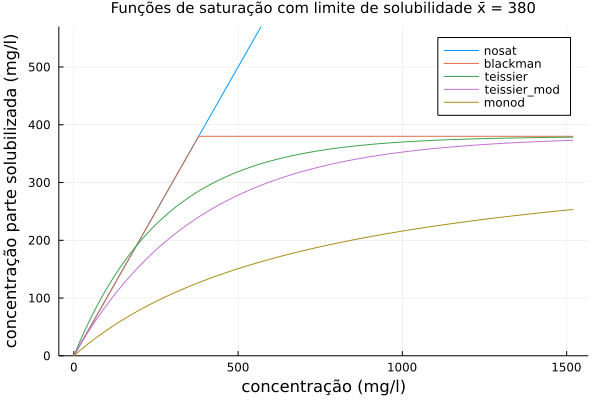

In [24]:
# Plot saturation functions
#
# solubility limit for the humulone alpha-acid in wort at 100C and pH about 5.2 (Spetsig)
x̄ = 380
x = 0.0:4.0x̄
plot(title="Funções de saturação com limite de solubilidade x̄ = $x̄", ylim=(0, 1.5*x̄), titlefont=10)
for f in SATFUNS
    plot!(x, x -> eval(f)(x, x̄), label="$f")
end
display(plot!(xlabel="concentração (mg/l)", ylabel="concentração parte solubilizada (mg/l)"))

### Equações diferenciais do sistema de reações químicas

In [25]:
"""
    dudt_nosat!(du, u, params, t)

Right hand side of the system of reaction equations

x' = -k₁x
y' = k₁x - k₂y

modeling the chain reaction X → Y → Z, with reaction rates k₁ and k₂,
respectively.
"""
function dudt_nosat!(du, u, params, t)
    x, y = u
    k₁, k₂ = params
    f = k₁ * x
    g = k₂ * y
    du[1] = - f
    du[2] = f - g
end

"""
    dudt_Blackman!(du, u, params, t)

Right hand side for the system of reaction equations with Blackman-type
saturation:

x' = -k₁ * min(x,x̄)
y' = k₁ * min(x,x̄) - k₂ * y

It models the chain reaction X → Y → Z, with reaction rates k₁ and k₂,
respectively, and with a hard threshold saturation behavior for the component x,
i.e. the reaction rate is dictated by the saturation limit x̄, once the saturation
is achieved, or by the concentration itself, even if it is close to the 
saturation limit.
"""
function dudt_Blackman!(du, u, params, t)
    x, y = u
    k₁, k₂, x̄ = params
    f = k₁ * min(x, x̄)
    g = k₂ * y
    du[1] = - f
    du[2] = f - g
end

"""
    dudt_Teissier!(du,u, params,t)

Right hand side for the system of reaction equations with Teisser-type
saturation behavior:

x' = -k₁ * x̄ * (1 - exp(-2 * log(2) * x / x̄))
y' = k₁ * x̄ * (1 - exp(-2 * log(2) * x / x̄)) - k₂ * y

It models the chain reaction X → Y → Z, with reaction rates k₁ and k₂,
respectively, and with a smoothed out saturation behavior as modeled by Teissier.
"""
function dudt_Teissier!(du, u, params, t)
    x, y = u
    k₁, k₂, x̄ = params
    f = k₁ * x̄ * (1 - exp(-2 * log(2) * x / x̄))
    g = k₂ * y
    du[1] = - f
    du[2] = f - g
end
 
"""
    dudt_Teissier_mod!(du, u, params, t)

Right hand side for the system of reaction equations with modified Teisser-type
saturation behavior:

x' = -k₁ * x̄ * (1 - exp( x / x̄ ))
y' = k₁ * x̄ * (1 - exp( x / x̄ )) - k₂ * y

It models the chain reaction X → Y → Z, with reaction rates k₁ and k₂,
respectively, and with a smoothed out saturation behavior as modeled by 
a slight modification of the Teissier model; see [`dudt_Teissier!`](@ref).
"""
function dudt_Teissier_mod!(du, u, params, t)
    x, y = u
    k₁, k₂, x̄ = params
    f = k₁ * x̄ * (1 - exp(- x / x̄))
    g = k₂ * y
    du[1] = - f
    du[2] = f - g
end

"""
    dudt_Monod!(du, u, params, t)

Right hand side for the system of reaction equations with Monod-type
saturation behavior:

x' = -k₁ * x̄ * x / (2 * x̄ + x)
y' = k₁ * x̄ * x / (2 * x̄ + x) - k₂ * y

It models the chain reaction X → Y → Z, with reaction rates k₁ and k₂,
respectively, and with a smoothed out saturation behavior as modeled by 
the Monod model.
"""
function dudt_Monod!(du, u, params, t)
    x, y = u
    k₁, k₂, x̄ = params
    f = k₁ * x̄ * x / ( 2 * x̄ + x )
    g = k₂ * y
    du[1] = - f
    du[2] = f - g
end

"""
    const RHSLAWS

List of implemented RHS reaction laws.
"""
const RHSLAWS = (
    :dudt_nosat!, :dudt_Blackman!, :dudt_Teissier!, :dudt_Teissier_mod!, :dudt_Monod!
)

nothing

## Dados

* Dados extraídos do artigo de Maule (direto da figura).

* Os dados são da concentração de humulone e iso-humulone tanto no mosto (apó a fervura) quanto no *hot-break*.

* O *hot-break* é um agregado de material coagulado e que decanta com o resfriamento do mosto após a fervura.

* Concentrações em mg/l.

![Fate of humulone during boil](../../../_assets/attachments/img/Maule-FateofHumuloneDuringWortBoilingandCooling-JInstBrewing-1966-Figure4.png)

In [27]:
humulone_in = [37.2; 79.1; 97.7; 118.6; 158.1; 190.7; 384.9; 672.1]
humulone_wort = [14.0; 24.4; 23.8; 34.9; 46.5; 52.3; 79.1; 99.4]
humulone_break = [7.0; 9.3; 10.5; 12.8; 15.1; 18.0; 62.2; 180.2]
isohumulone_wort = [27.3; 39.5; 51.2; 59.3; 76.7; 91.9; 159.3; 206.4]
isohumulone_break = [1.7; 4.1; 5.8; 7.0; 8.7; 12.2; 46.5; 96.5]
humulone_remaining = humulone_wort + humulone_break
isohumulone_remaining = isohumulone_wort + isohumulone_break
nothing

### Exploração dos dados

* Vamos examinar os dados, traçando os gráficos de humulone e iso-humulone, respectivamente.

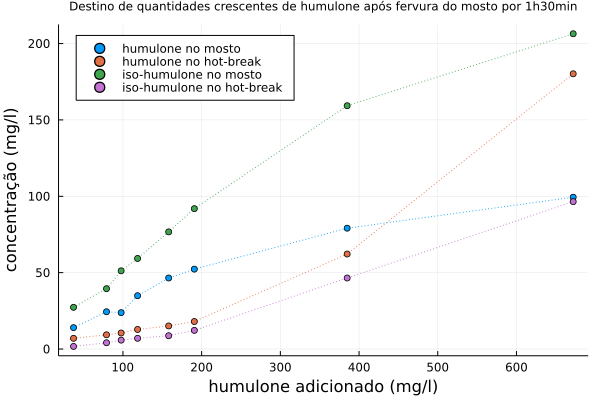

In [28]:
plot(humulone_in, humulone_wort, label=false, color=1, linestyle=:dot)
scatter!(humulone_in, humulone_wort, label="humulone no mosto", legend=:topleft, color=1)
plot!(humulone_in, humulone_break, label=false, color=2, linestyle=:dot)
scatter!(humulone_in, humulone_break, label="humulone no hot-break", color=2)
plot!(humulone_in, isohumulone_wort, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, isohumulone_wort, label="iso-humulone no mosto", color=3)
plot!(humulone_in, isohumulone_break, label=false, color=4, linestyle=:dot)
scatter!(humulone_in, isohumulone_break, label="iso-humulone no hot-break", color=4)
plot!(title="Destino de quantidades crescentes de humulone após fervura do mosto por 1h30min",
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="concentração (mg/l)")

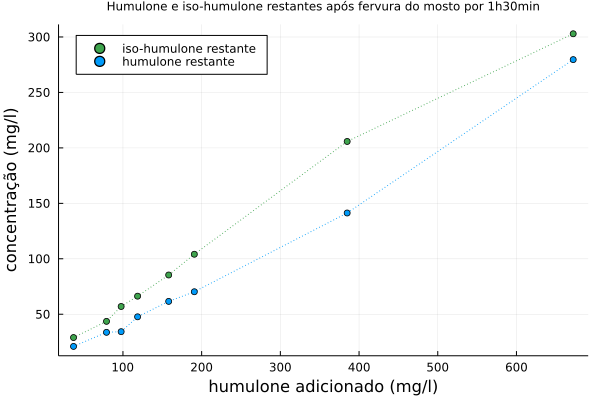

In [29]:
plot(humulone_in, isohumulone_remaining, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, isohumulone_remaining , label="iso-humulone restante",  color=3)
plot!(humulone_in, humulone_remaining, label=false, color=1, linestyle=:dot)
scatter!(humulone_in, humulone_remaining , label="humulone restante", color=1)
plot!(title="Humulone e iso-humulone restantes após fervura do mosto por 1h30min", legend=:topleft,
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="concentração (mg/l)")

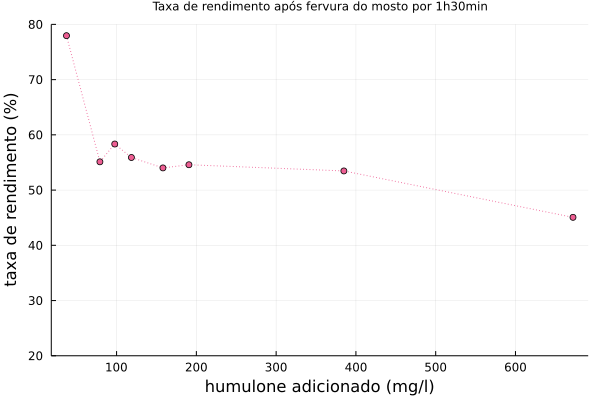

In [30]:
plot(humulone_in, 100 * isohumulone_remaining ./ humulone_in,  label=false, color=7, linestyle=:dot, ylims=(20.0, 80.0))
scatter!(humulone_in, 100 * isohumulone_remaining ./ humulone_in,  label=false, color=7, linestyle=:dot)
plot!(title="Taxa de rendimento após fervura do mosto por 1h30min", titlefont=8, xlabel="humulone adicionado (mg/l)", 
        ylabel="taxa de rendimento (%)")

## Análise

### Parâmetros para a análise

In [17]:
# Both reaction rates from Malowicki and Shellhammer [Agric. Food Chem., Vol. 53, No. 11, 2005], Table 3 for humulone at 100C
k₁ = 0.01141 
k₂ = 0.00263
# solubility limit (mg/l) for the alpha-acid in wort at 100C and pH about 5.2 (Spetsig)
x̄ = 380
# solubility limit (mg/l) for the iso-alpha-acid at 100C and pH 5.2 ???  
ȳ = 1000 # não usaremos esse dado nessa análise
# parâmeros
β₀ = [k₁, k₂, x̄]
# tempo de fervura
tspan = (0.0, 90.0)

nothing

### Solução da reação pelos diversos modelos e sem ajuste

In [18]:
isohumulone_model = Dict()
humulone_model = Dict()
for rhs in RHSLAWS
    isohumulone_model[rhs] = zero(humulone_in)
    humulone_model[rhs] = zero(humulone_in)
    for (i,h) in enumerate(humulone_in)
        # lupulagem inicial (humulone e iso-humulone)
        u0 = [h; 0.0]
        prob = ODEProblem(eval(rhs), u0, tspan, β₀)
        sol = solve(prob,Tsit5())
        humulone_model[rhs][i], isohumulone_model[rhs][i] = sol(90.0)
    end
end

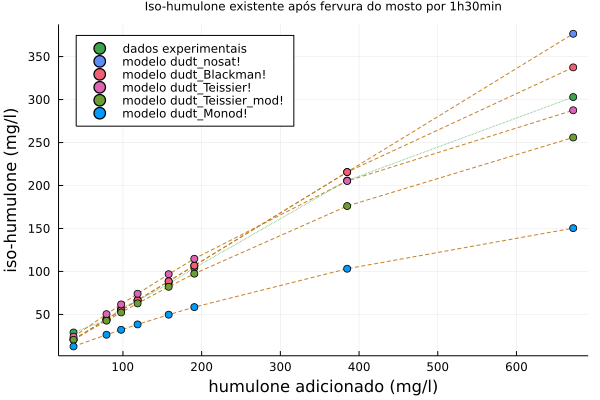

In [19]:
plot(humulone_in, isohumulone_remaining, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, isohumulone_remaining , label="dados experimentais", legend=:topleft, color=3)
for (i,rhs) in enumerate(RHSLAWS)
    plot!(humulone_in, isohumulone_model[rhs], label=false, color=8, linestyle=:dash)
    scatter!(humulone_in, isohumulone_model[rhs], label="modelo $rhs", color=12+i)
end
plot!(title="Iso-humulone existente após fervura do mosto por 1h30min",
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="iso-humulone (mg/l)")

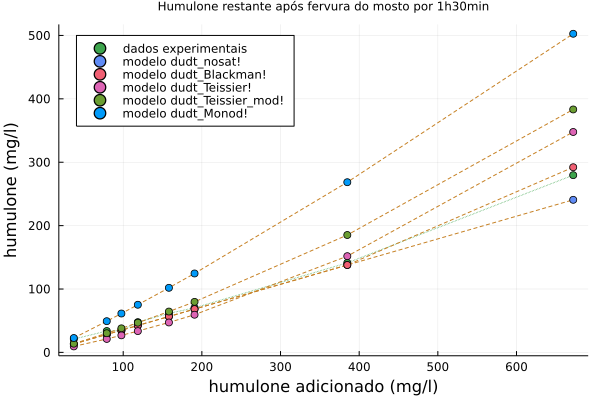

In [20]:
plot(humulone_in, humulone_remaining, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, humulone_remaining , label="dados experimentais", legend=:topleft, color=3)
for (i,rhs) in enumerate(RHSLAWS)
    plot!(humulone_in, humulone_model[rhs], label=false, color=8, linestyle=:dash)
    scatter!(humulone_in, humulone_model[rhs], label="modelo $rhs", color=12+i)
end
plot!(title="Humulone restante após fervura do mosto por 1h30min",
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="humulone (mg/l)")

## Ajuste dos modelos

### Ajuste pelo humulone via LsqFit

* O `LsqFit.jl` é um pacote simples e que funciona muito bem para o ajuste de funções escalares.

* Vamos utilizá-lo para ajustar os parâmetros aos dados de iso-humulone restante.

In [21]:
model = Dict()
fit = Dict()
N = length(isohumulone_remaining)
ih_mean = mean(isohumulone_remaining)
ih_ss_tot = N * var(isohumulone_remaining)
for (i,rhs) in enumerate(RHSLAWS)
    model[rhs] = (h, β) -> solve(ODEProblem(eval(rhs), [h,0.0], (0.0, 90.0), vcat(β, [x̄])),Tsit5())(90.0)[2]
    fit[rhs] = curve_fit((h,β) -> model[rhs].(h, Ref(β)), humulone_in, isohumulone_remaining, β₀[1:2])    
    β = fit[rhs].param
    ih_ss_reg = sum(abs2, reduce(vcat, model[rhs].(humulone_in, Ref(β))) .- ih_mean)
    ih_r_sq = ih_ss_reg/ih_ss_tot
    ih_ss_res = sum(abs2, reduce(vcat, model[rhs].(humulone_in, Ref(β))) - isohumulone_remaining)
    ih_rms = sqrt(ih_ss_res/N)
    println("$rhs")
    println("Parâmetros (k₁, k₂): $β")
    println("R-quadrado isohumolone: $ih_r_sq")
    println("RMS isohumulone: $ih_rms")
    println()
end

dudt_nosat!
Parâmetros (k₁, k₂): [0.008631760661667261, 0.002257236735145613]
R-quadrado isohumolone: 1.027887703474084
RMS isohumulone: 13.329220883858614

dudt_Blackman!
Parâmetros (k₁, k₂): [0.009017424697244402, 0.0004900353420956559]
R-quadrado isohumolone: 0.9144030912436754
RMS isohumulone: 3.66691398496186

dudt_Teissier!
Parâmetros (k₁, k₂): [0.015499375937121496, 0.006940467309606495]
R-quadrado isohumolone: 0.8839997732099701
RMS isohumulone: 3.494807527924975

dudt_Teissier_mod!
Parâmetros (k₁, k₂): [0.01587346971038533, 0.004665427108741152]
R-quadrado isohumolone: 0.8784681374727915
RMS isohumulone: 3.8355465566136164

dudt_Monod!
Parâmetros (k₁, k₂): [0.02606452687751667, 0.0025606064844254186]
R-quadrado isohumolone: 0.8749924239536672
RMS isohumulone: 4.268874163998897



### Ajuste por humulone e iso-humulone via Optim

#### Ajustando parâmetros de reação

* Mas fixando limite de solubilidade $\bar x$ conhecido.

In [22]:
model = Dict()
result = Dict()
N = length(humulone_remaining)
h_mean = mean(humulone_remaining)
ih_mean = mean(isohumulone_remaining)
h_ss_tot = N * var(humulone_remaining)
ih_ss_tot = N * var(isohumulone_remaining)
for (i,rhs) in enumerate(RHSLAWS)
    model[rhs] = (h, β) -> solve(ODEProblem(eval(rhs), [h,0.0], (0.0, 90.0), vcat(β, [x̄])),Tsit5())(90.0)
    custo(β) = sum(abs2, [humulone_remaining isohumulone_remaining] - reduce(hcat, model[rhs].(humulone_in, Ref(β)))')
    result[rhs] = optimize(custo, β₀[1:2])
    β = Optim.minimizer(result[rhs])
    sol = model[rhs].(humulone_in, Ref(β))
    h_ss_reg = sum(abs2, getindex.(sol,1) .- h_mean)
    ih_ss_reg = sum(abs2, getindex.(sol,2) .- ih_mean)
    h_r_sq = h_ss_reg/h_ss_tot
    ih_r_sq = ih_ss_reg/ih_ss_tot
    println("$rhs")
    println("Parâmetros (k₁, k₂): $β")
    println("Mínimo: $(Optim.minimum(result[rhs]))")
    println("R-quadrado humolone: $h_r_sq")
    println("R-quadrado isohumolone: $ih_r_sq")
    println("RMS: $(√Optim.minimum(result[rhs])/2/N)")
    println()
end

dudt_nosat!
Parâmetros (k₁, k₂): [0.010144415635002572, 0.004285811789269366]
Mínimo: 1799.2582466834745
R-quadrado humolone: 0.84526538213376
R-quadrado isohumolone: 1.0278880074766725
RMS: 2.6511040202352154

dudt_Blackman!
Parâmetros (k₁, k₂): [0.011553675881904958, 0.004398147591808766]
Mínimo: 692.9510993536404
R-quadrado humolone: 0.9712917740806674
R-quadrado isohumolone: 0.9726468344949818
RMS: 1.6452477721760204

dudt_Teissier!
Parâmetros (k₁, k₂): [0.01334726901671078, 0.004892966324933721]
Mínimo: 3131.59383768532
R-quadrado humolone: 1.1772496051236991
R-quadrado isohumolone: 0.8295777217181953
RMS: 3.4975403397899902

dudt_Teissier_mod!
Parâmetros (k₁, k₂): [0.01576410469488406, 0.004567620758076591]
Mínimo: 1531.7371758663865
R-quadrado humolone: 1.0929344849359601
R-quadrado isohumolone: 0.8767116698774775
RMS: 2.4460883760052643

dudt_Monod!
Parâmetros (k₁, k₂): [0.029690161789117438, 0.004433290937858485]
Mínimo: 1067.3083103710526
R-quadrado humolone: 1.05123474003183

#### Ajustando parâmetros de reação e limite de solubilidade

In [23]:
model = Dict()
result = Dict()
N = length(humulone_remaining)
h_mean = mean(humulone_remaining)
ih_mean = mean(isohumulone_remaining)
h_ss_tot = N * var(humulone_remaining)
ih_ss_tot = N * var(isohumulone_remaining)
for (i,rhs) in enumerate(RHSLAWS)
    model[rhs] = (h, β) -> solve(ODEProblem(eval(rhs), [h,0.0], (0.0, 90.0), β),Tsit5())(90.0)
    custo(β) = sum(abs2, [humulone_remaining isohumulone_remaining] - reduce(hcat, model[rhs].(humulone_in, Ref(β)))')
    result[rhs] = optimize(custo, β₀)
    β = Optim.minimizer(result[rhs])
    sol = model[rhs].(humulone_in, Ref(β))
    h_ss_reg = sum(abs2, getindex.(sol,1) .- h_mean)
    ih_ss_reg = sum(abs2, getindex.(sol,2) .- ih_mean)
    h_r_sq = h_ss_reg/h_ss_tot
    ih_r_sq = ih_ss_reg/ih_ss_tot
    println("$rhs")
    println("Parâmetros (k₁, k₂, x̄): $β")
    println("Mínimo: $(Optim.minimum(result[rhs]))")
    println("R-quadrado humolone: $h_r_sq")
    println("R-quadrado isohumolone: $ih_r_sq")
    println("RMS: $(√Optim.minimum(result[rhs])/2/N)")
    println()
end

dudt_nosat!
Parâmetros (k₁, k₂, x̄): [0.010144414995603477, 0.004285808306952883, 446.9781075146373]
Mínimo: 1799.2582466828628
R-quadrado humolone: 0.8452654807656461
R-quadrado isohumolone: 1.0278882591240854
RMS: 2.651104020234765

dudt_Blackman!
Parâmetros (k₁, k₂, x̄): [0.01146028858300894, 0.004359845827428641, 385.4713803573609]
Mínimo: 691.3158176971742
R-quadrado humolone: 0.9662006505081779
R-quadrado isohumolone: 0.9773926432298784
RMS: 1.6433053316044426

dudt_Teissier!
Parâmetros (k₁, k₂, x̄): [0.009243128310965382, 0.004309517864384318, 1005.4298395740384]
Mínimo: 739.2449525993791
R-quadrado humolone: 0.9790067569077386
R-quadrado isohumolone: 0.9457493497186616
RMS: 1.69931621427306

dudt_Teissier_mod!
Parâmetros (k₁, k₂, x̄): [0.01281368245065706, 0.00430951157355529, 725.2671893158265]
Mínimo: 739.2449525899958
R-quadrado humolone: 0.9790065770093658
R-quadrado isohumolone: 0.9457499024112103
RMS: 1.6993162142622753

dudt_Monod!
Parâmetros (k₁, k₂, x̄): [0.02578947385

**Observação:**

* Além de ter o menor RMS, note quão próximos os parâmetros do ajuste desse modelo ficaram dos extraídos da literatura.

In [24]:
isohumulone_model_adj = Dict()
humulone_model_adj = Dict()
for rhs in RHSLAWS
    isohumulone_model_adj[rhs] = zero(humulone_in)
    humulone_model_adj[rhs] = zero(humulone_in)
    for (i,h) in enumerate(humulone_in)
        # lupulagem inicial (humulone e iso-humulone)
        u0 = [h; 0.0]
        prob = ODEProblem(eval(rhs), u0, tspan, Optim.minimizer(result[rhs]))
        sol = solve(prob, Tsit5())
        humulone_model_adj[rhs][i], isohumulone_model_adj[rhs][i] = sol(90.0)
    end
end

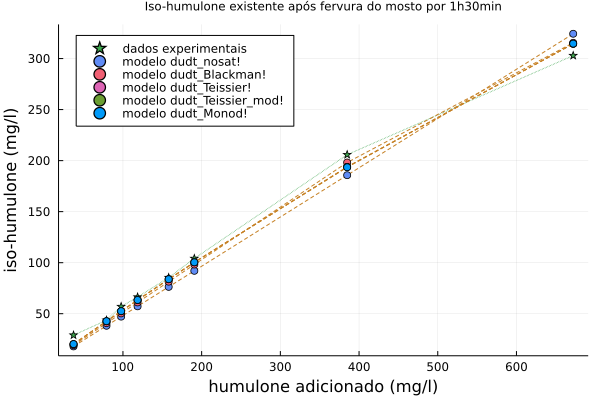

In [25]:
plot(humulone_in, isohumulone_remaining, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, isohumulone_remaining, marker=:star, label="dados experimentais", legend=:topleft, color=3)
for (i,rhs) in enumerate(RHSLAWS)
    plot!(humulone_in, isohumulone_model_adj[rhs], label=false, color=8, linestyle=:dash)
    scatter!(humulone_in, isohumulone_model_adj[rhs], label="modelo $rhs", color=12+i)
end
plot!(title="Iso-humulone existente após fervura do mosto por 1h30min",
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="iso-humulone (mg/l)")

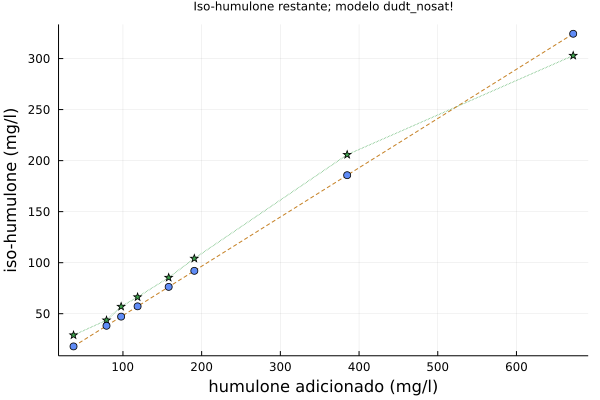

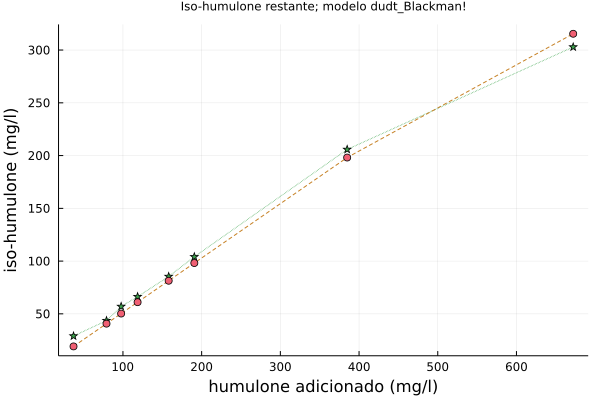

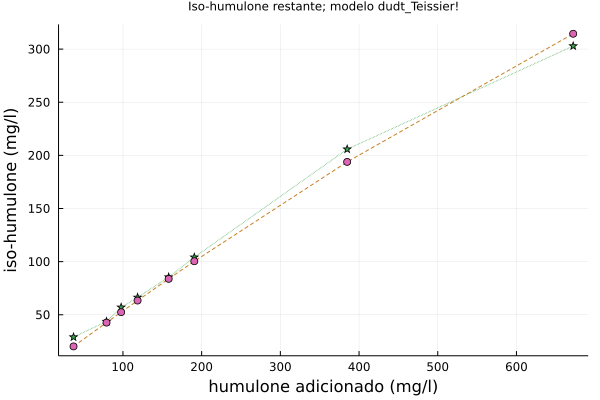

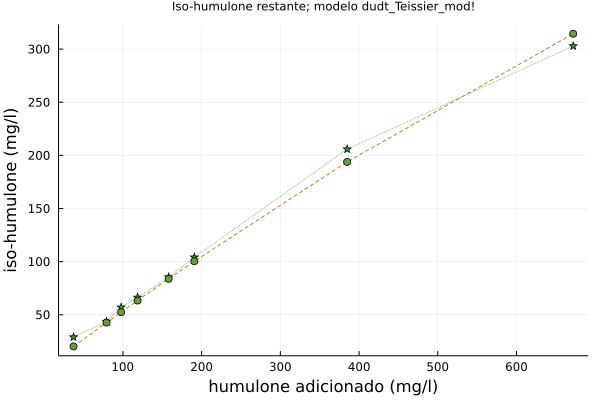

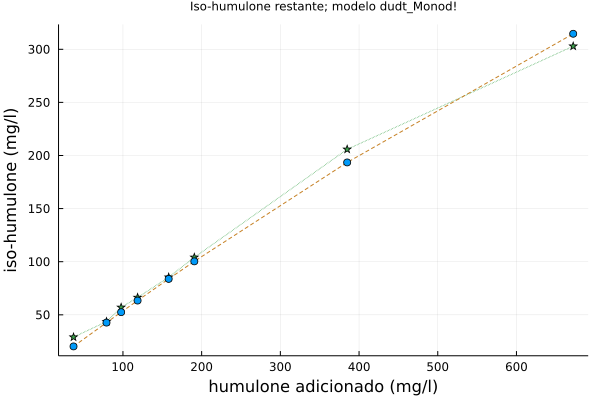

In [26]:
for (i, rhs) in enumerate(RHSLAWS)
    p = plot(humulone_in, isohumulone_remaining, label=false, color=3, linestyle=:dot)
    scatter!(p, humulone_in, isohumulone_remaining, marker=:star, legend=nothing, color=3)
    plot!(p, humulone_in, isohumulone_model_adj[rhs], color=8, linestyle=:dash)
    scatter!(p, humulone_in, isohumulone_model_adj[rhs], color=12+i)
    plot!(p, title="Iso-humulone restante; modelo $rhs",
        titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="iso-humulone (mg/l)")
    display(p)
end

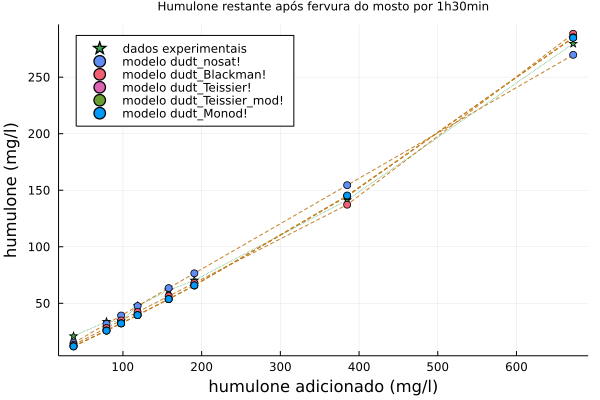

In [27]:
plot(humulone_in, humulone_remaining, label=false, color=3, linestyle=:dot)
scatter!(humulone_in, humulone_remaining , marker=:star,
    label="dados experimentais", legend=:topleft, color=3)
for (i,rhs) in enumerate(RHSLAWS)
    plot!(humulone_in, humulone_model_adj[rhs], label=false, color=8, linestyle=:dash)
    scatter!(humulone_in, humulone_model_adj[rhs], label="modelo $rhs", color=12+i)
end
plot!(title="Humulone restante após fervura do mosto por 1h30min",
    titlefont=8, xlabel="humulone adicionado (mg/l)", ylabel="humulone (mg/l)")

## Evolução temporal (WIP)

* Vamos analisar, agora, a evolução temporal das concentrações de humulone e iso-humulone.

* Dados obtidos da figura 1 do artigo do Maule.

* Cada 360 pixels equivalem aproximadamente a 1h no eixo horizontal e a 20mg/l no eixo vertical.

* Os números abaixo são aproximações com mais ou menos 2 pixels de precisão.

* Convertidos para mg/l multiplicando-se por 1/18 mg/l/pixel = (20mg/l)/(360 pixels).

* As medições foram feitas a cada 30 minutos, em um período de 3h de fervura.

![Fate of humulone](../../../_assets/attachments/img/Maule-FateofHumuloneDuringWortBoilingandCooling-JInstBrewing-1966-Figure1.png)

In [11]:
tempos = 60.0 * (0.5:0.5:3.0)
hum_wort = [670, 597, 523, 448, 386, 333]./18
hum_break = [117, 115, 114, 95, 72, 56]./18
iso_wort = [552, 820, 958, 1038, 1095, 1130]./18
iso_break = [40, 49, 69, 79, 100, 116]./18
nothing

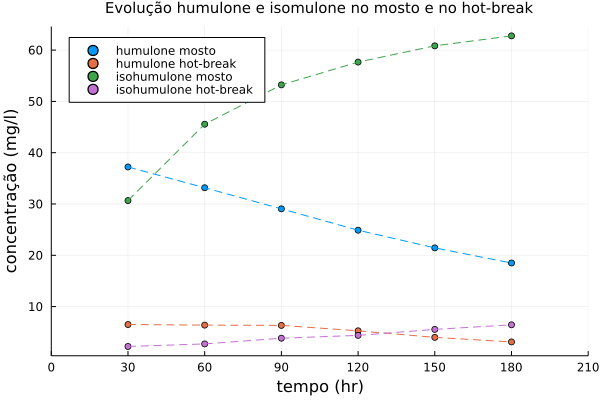

In [12]:
scatter(tempos, hum_wort, color=1, label="humulone mosto")
plot!(tempos, hum_wort, color=1, linestyle=:dash, label=false)
scatter!(tempos, hum_break, color=2, label="humulone hot-break")
plot!(tempos, hum_break, color=2, linestyle=:dash, label=false)
scatter!(tempos, iso_wort, color=3, label="isohumulone mosto")
plot!(tempos, iso_wort, color=3, linestyle=:dash, label=false)
scatter!(tempos, iso_break, color=4, label="isohumulone hot-break")
plot!(tempos, iso_break, color=4, linestyle=:dash, label=false)
plot!(title="Evolução humulone e isomulone no mosto e no hot-break", titlefont=10,
    xlabel = "tempo (hr)", ylabel="concentração (mg/l)", 
    xlim=(0.0, 3.5 * 60.0), legend=:topleft)

In [13]:
rhs = :dudt_Blackman!
β = Optim.minimizer(result[rhs])
println(β)
println(β₀)
prob = ODEProblem(eval(rhs), [20.0, 50.0], (0.0, 180.0), β)
sol = solve(prob, Tsit5())
nothing

UndefVarError: UndefVarError: result not defined

In [14]:
scatter(tempos, hum_wort + hum_break, color=1, label="humulone (dados)")
scatter!(tempos, iso_wort + iso_break, color=2, label="iso-humulone (dados)")
plot!(sol, label=["humulone" "isohumulone"])
plot!(title="Evolução humulone e iso-humulone (dados e modelo $rhs)", titlefont=10,
    xlabel = "tempo (s)", ylabel="concentração (mg/l)", 
    xlim=(0.0, 3.5 * 60.0), legend=:topleft)

UndefVarError: UndefVarError: sol not defined